In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,plot_xgb_feature_importance


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

################################# 数据 读取-处理 开始#################################
sheet = pd.read_excel('data_input/美国10年通胀预期Non-Trend_F0.1.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['美国10年通胀预期Non-Trend/F0.1'].last_valid_index()

################################# 处理数据 让他们更适合 用来预测之后一个月的数据  #################################

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet

sheet.columns  

Index(['美国10年通胀预期Non-Trend/F0.1', '美国ISM制造业PMI\新订单比自有库存', '美国费城+纽约制造业活动',
       '美国曼海姆二手车价格指数同比', '美国经济惊喜指数', 'WTI原油期货价格', '美国经济政策不确定性指数/7DMA',
       'VIX指数/20DMA'],
      dtype='object')

In [4]:
# 尝试多个可能的文件路径
file_paths = [
    os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/wti_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/wti_合并数据.xlsx")
]

file_path = None
for path in file_paths:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path = path
        break

if file_path is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.read_excel(file_path, sheet_name='Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['wti原油期货价格'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
    sheet1.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.tail()

,Date,WTI原油期货价格预测
4,2025-11-10,53.70
3,2025-11-11,51.33
2,2025-11-12,52.39
1,2025-11-13,52.24
0,2025-11-14,52.14


In [5]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', 'WTI原油期货价格预测']],
    on='Date',
    how='left'
)
sheet_daily['WTI原油期货价格'] = sheet_daily['WTI原油期货价格'].fillna(sheet_daily['WTI原油期货价格预测'])
sheet_daily = sheet_daily.drop(columns=['WTI原油期货价格预测'])
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')


In [6]:


################################# 处理缺失值 #################################
fill_methods = {
    '美国费城+纽约制造业活动': 'interpolate',
    '美国ISM制造业PMI\新订单比自有库存': 'interpolate',
    '美国曼海姆二手车价格指数同比': 'interpolate',
    '美国经济惊喜指数': 'interpolate',
    '美国经济政策不确定性指数/7DMA': 'interpolate', 
    'VIX指数/20DMA': 'interpolate',
    '美国经济政策不确定性指数/7DMA': 'interpolate',
   
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, '美国10年通胀预期Non-Trend/F0.1'] = sheet.loc[:last_day, '美国10年通胀预期Non-Trend/F0.1'].interpolate(method='linear')

sheet.tail()


,美国10年通胀预期Non-Trend/F0.1,WTI原油期货价格,美国费城+纽约制造业活动,美国ISM制造业PMI\新订单比自有库存,美国曼海姆二手车价格指数同比,美国经济惊喜指数,美国经济政策不确定性指数/7DMA,VIX指数/20DMA
Date,,,,,,,,
2025-11-17,NaN,NaN,-2.1,1.0252,0.02,13.8,751.2586,18.2485
2025-11-18,NaN,NaN,-2.1,1.0252,0.02,13.8,751.2586,18.2485
2025-11-19,NaN,NaN,-2.1,1.0252,0.02,13.8,751.2586,18.2485
2025-11-20,NaN,NaN,-2.1,1.0252,0.02,13.8,751.2586,18.2485
2025-11-21,NaN,NaN,-2.1,1.0252,0.02,13.8,751.2586,18.2485


In [7]:
#################################  因子处理  #################################

sheet['美国费城+纽约制造业活动_提前20天'] = sheet['美国费城+纽约制造业活动'].shift(20) 
sheet['美国ISM制造业PMI\新订单比自有库存_提前15天'] = sheet['美国ISM制造业PMI\新订单比自有库存'].shift(20)
sheet['美国曼海姆二手车价格指数同比_提前100天'] = sheet['美国曼海姆二手车价格指数同比'].shift(83)
sheet['美国经济惊喜指数_提前20天'] = sheet['美国经济惊喜指数'].shift(25)
sheet['美国经济政策不确定性指数/7DMA_提前20天'] = sheet['美国经济政策不确定性指数/7DMA'].shift(20)
sheet['VIX指数/20DMA_提前25天'] = sheet['VIX指数/20DMA'].shift(25)
sheet['美国经济政策不确定性指数/7DMA_提前20天'] = sheet['美国经济政策不确定性指数/7DMA'].shift(20)

sheet['VIX指数/20DMA_提前25天_逆序'] = reverse_column(sheet, 'VIX指数/20DMA_提前25天')


In [8]:
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-03-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['美国10年通胀预期Non-Trend/F0.1'].notna())
]

################################# 数据 读取-处理 结束 #################################

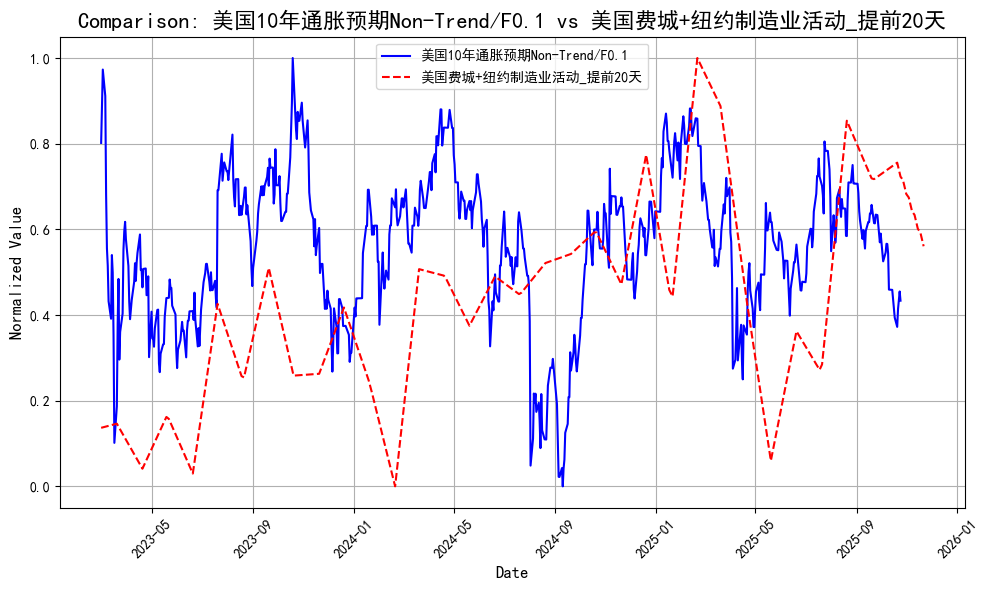

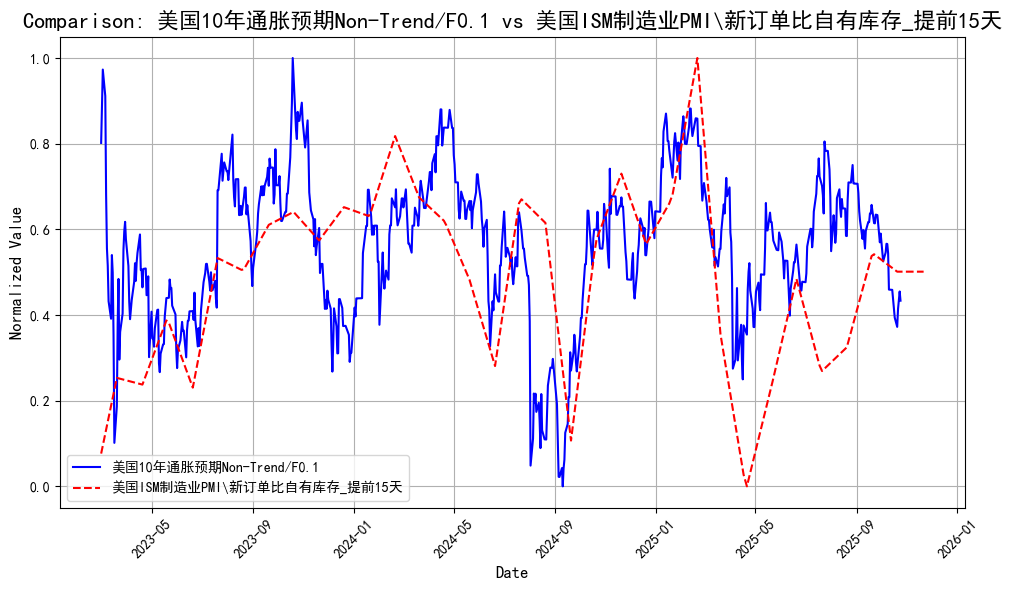

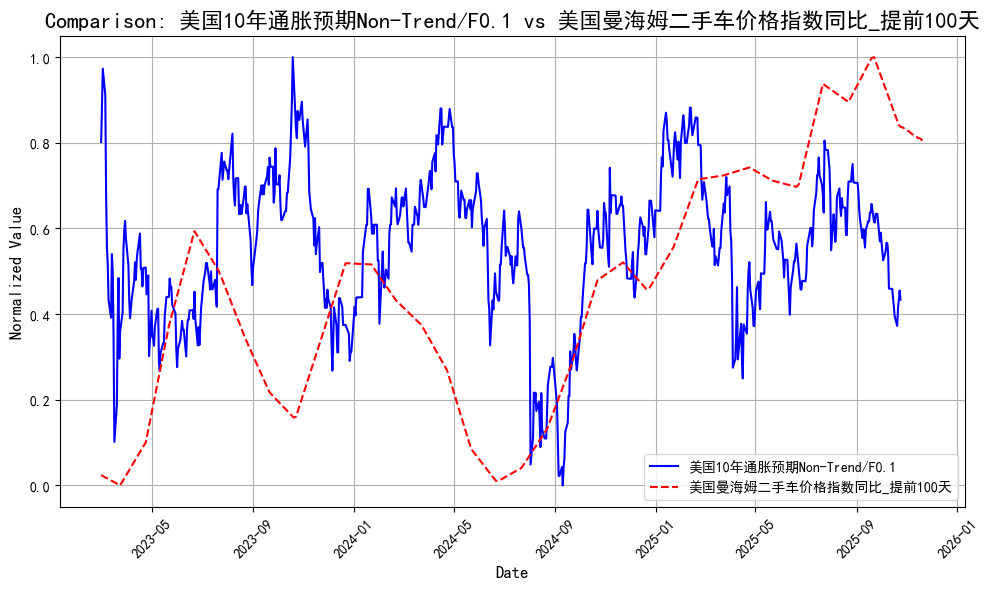

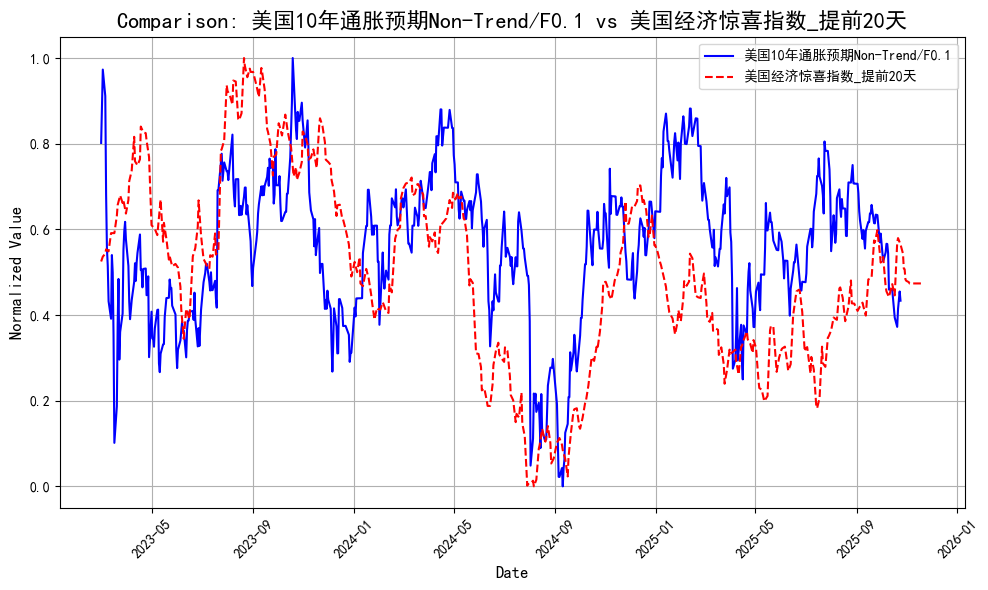

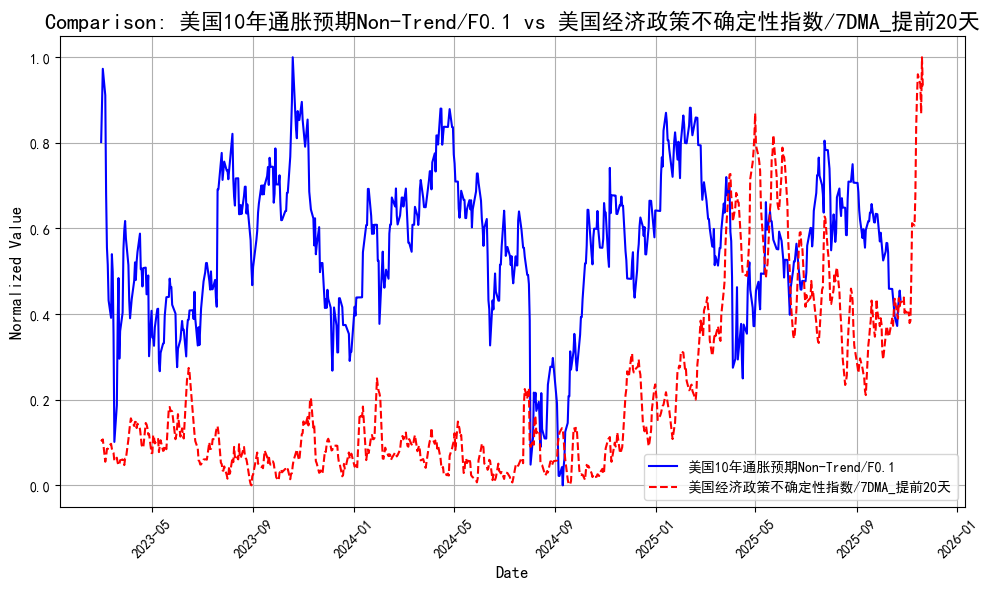

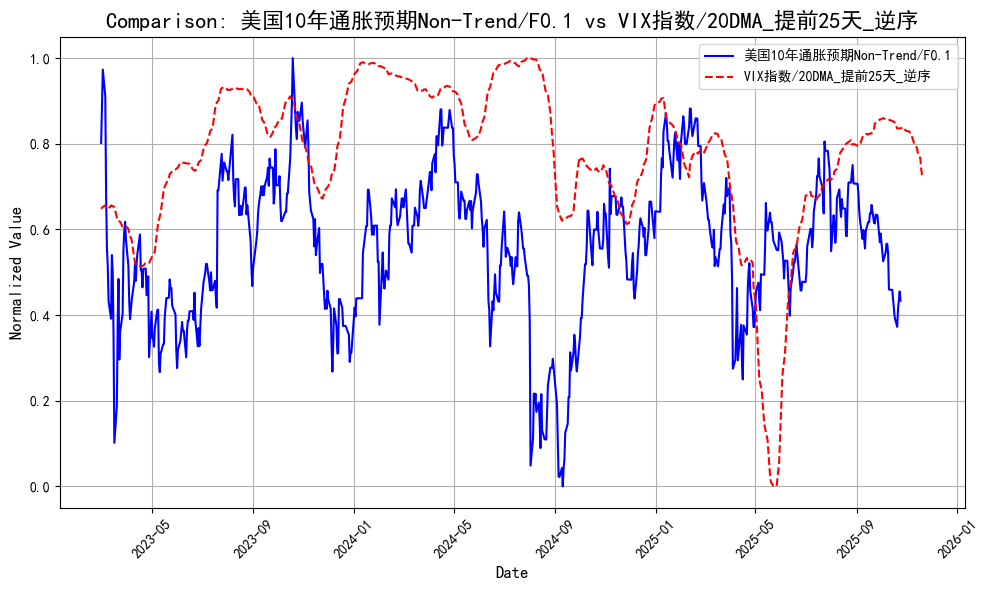

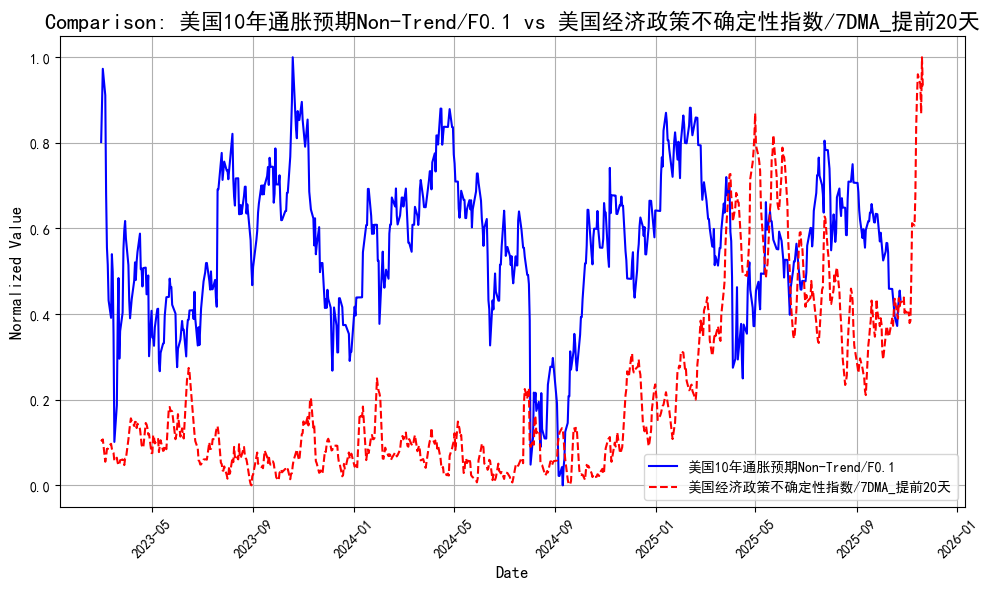

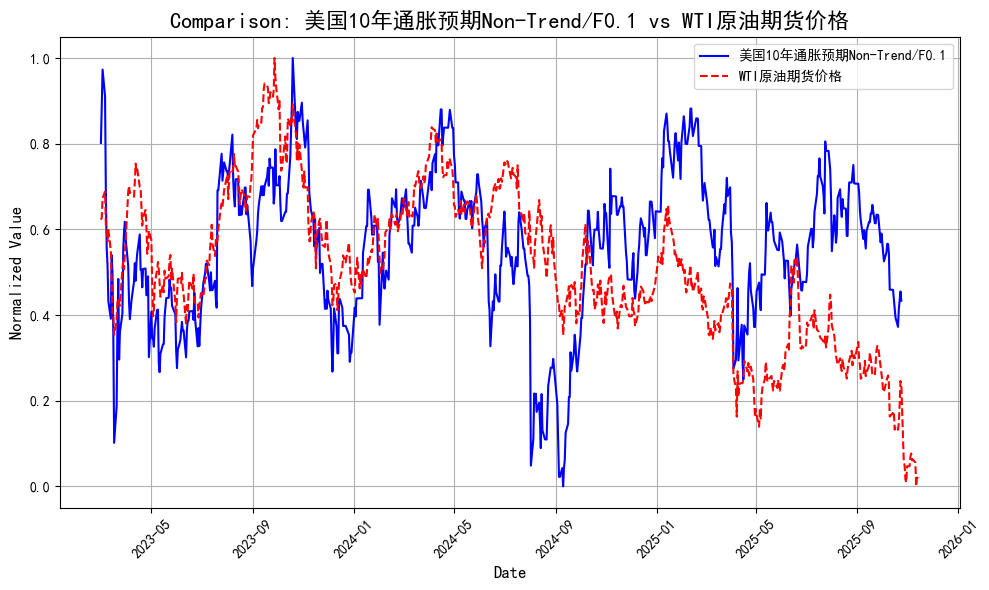

In [9]:
################################# X 和 Y 对比 观察领先性 #################################
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='美国10年通胀预期Non-Trend/F0.1', 
    compare_cols=[
        '美国费城+纽约制造业活动_提前20天',
        '美国ISM制造业PMI\新订单比自有库存_提前15天',
        '美国曼海姆二手车价格指数同比_提前100天',
        '美国经济惊喜指数_提前20天',
        '美国经济政策不确定性指数/7DMA_提前20天',
        'VIX指数/20DMA_提前25天_逆序',
        '美国经济政策不确定性指数/7DMA_提前20天',
        'WTI原油期货价格'
       ]
)

In [10]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 30
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '美国费城+纽约制造业活动_提前20天',
        #'美国ISM制造业PMI\新订单比自有库存_提前15天',
        '美国曼海姆二手车价格指数同比_提前100天',
        '美国经济惊喜指数_提前20天',
        'VIX指数/20DMA_提前25天_逆序',
        '美国经济政策不确定性指数/7DMA_提前20天',
        'WTI原油期货价格'
]

predict_column = '美国10年通胀预期Non-Trend/F0.1'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.04,  # 较小的学习率
    'max_depth': 12,  # 控制树的深度防止过拟合
    'min_child_weight': 5,  # 控制过拟合
    'subsample': 0.8,  # 随机采样防止过拟合
    'colsample_bytree': 0.8,  # 特征随机采样
    'gamma': 0.001,  # 控制分裂
    'reg_alpha': 0,  # L1正则化
    'reg_lambda': 1,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
    #'max_delta_step': 5,
    'tree_method': 'auto',
    'booster': 'gblinear',  # 使用线性模型作为基学习器
}

num_boost_round = 3000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:0.04266	train-rmse:0.07877


[500]	eval-rmse:0.04339	train-rmse:0.06788


[633]	eval-rmse:0.04339	train-rmse:0.06788


训练集 MSE (DMatrix): 0.0051, 训练集 R² (DMatrix): 0.2675
测试集 MSE (DMatrix): 0.0019, 测试集 R² (DMatrix): -0.1131


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [10:38:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "tree_method" } are not used.

  self.starting_round = model.num_boosted_rounds()


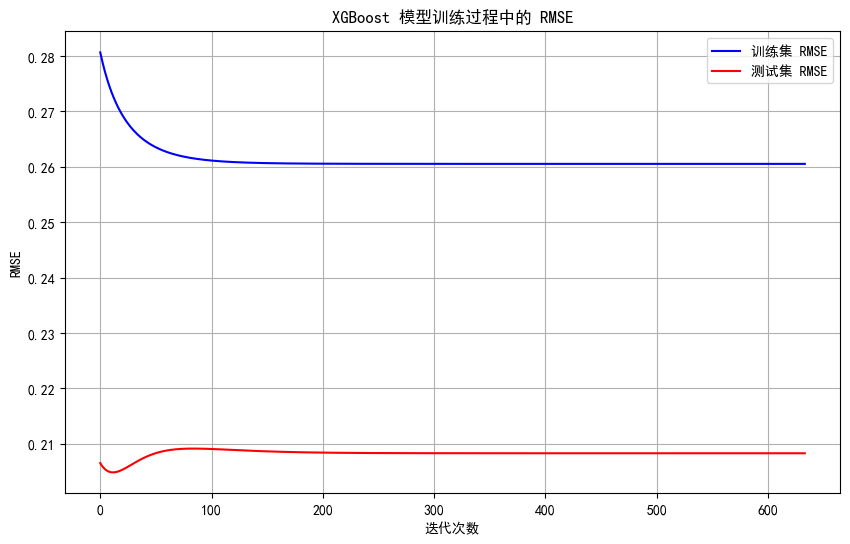

In [11]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=100
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:0.08179


[100]	train-rmse:0.07033


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [10:38:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "tree_method" } are not used.

  self.starting_round = model.num_boosted_rounds()


[200]	train-rmse:0.06996


[300]	train-rmse:0.06994


[400]	train-rmse:0.06994


[500]	train-rmse:0.06994


[600]	train-rmse:0.06994


[653]	train-rmse:0.06994


全部数据 MSE: 0.0049, 全部数据 R²: 0.2788


In [13]:
'''
#绘制因子重要性
plot_xgb_feature_importance(model_all, X_train)
'''


'\n#绘制因子重要性\nplot_xgb_feature_importance(model_all, X_train)\n'

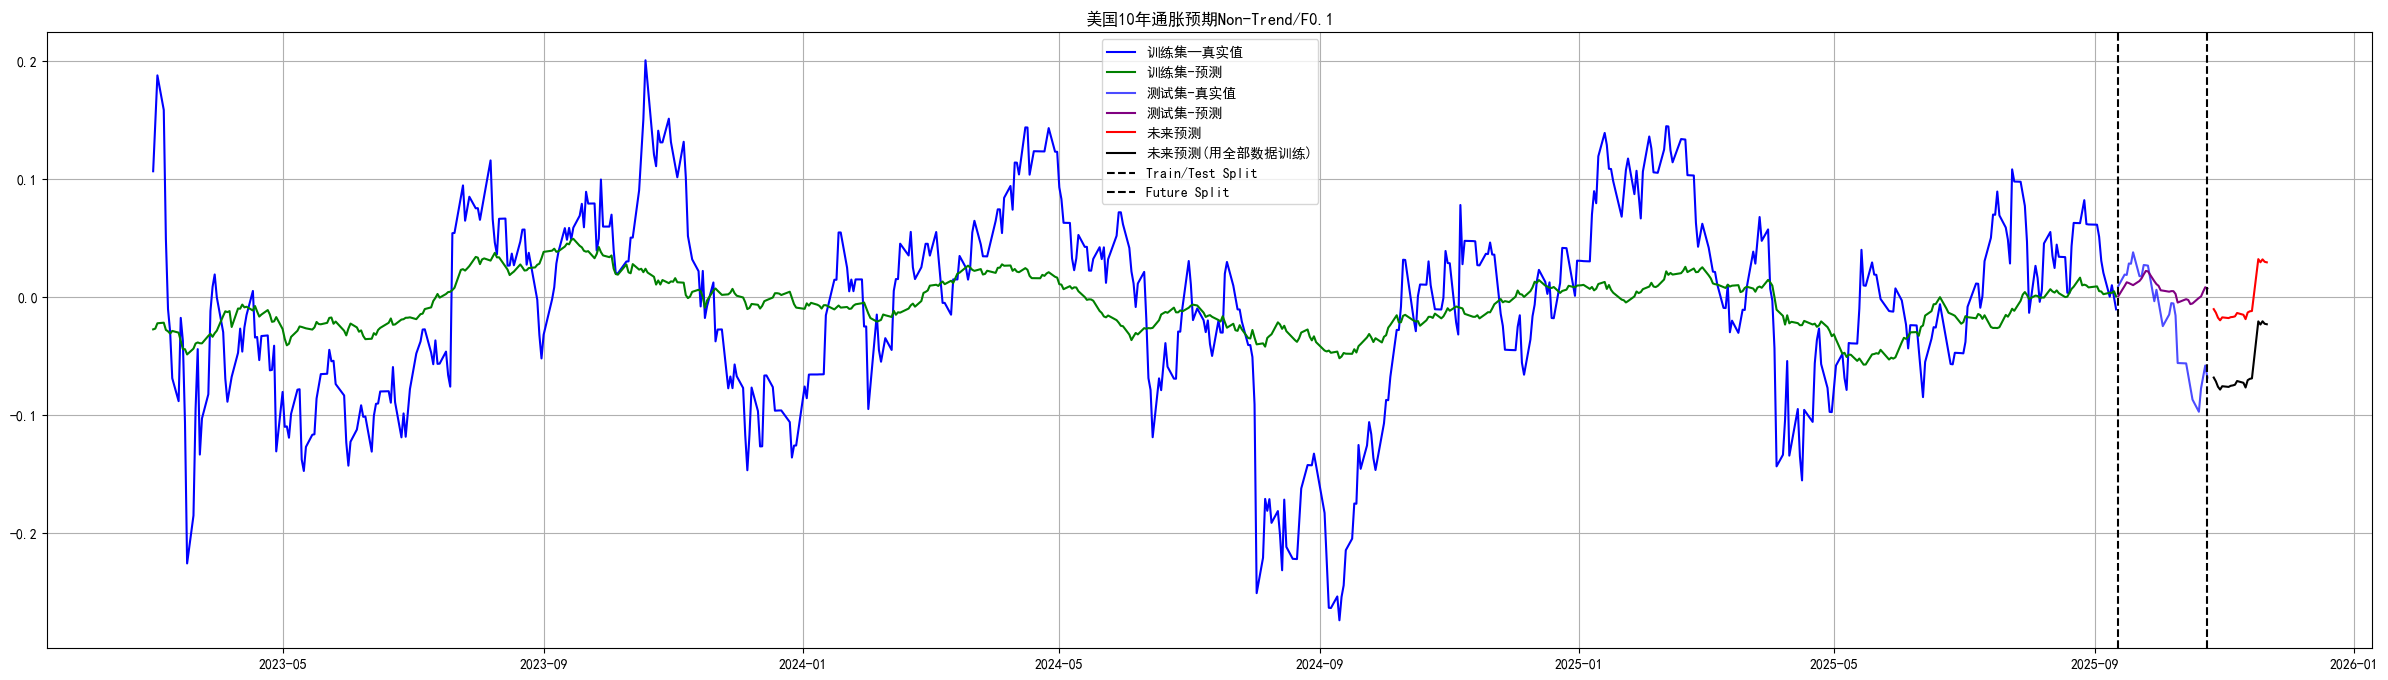

In [14]:
plt.figure(figsize=(30, 8))
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('美国10年通胀预期Non-Trend/F0.1')
plt.legend()
plt.grid(True)
plt.show()

---

In [15]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并历史真实值和预测值
merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
# 按日期排序 倒叙
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel 在 eta 文件夹里
merged_df_daily.to_excel('eta/美国10年通胀预期Non-Trend_F0.1_合并数据.xlsx', index=False,float_format='%.4f')
merged_df_daily

,Date,真实值,预测值
684,2025/11/21,NaN,-0.023009
683,2025/11/20,NaN,-0.022610
682,2025/11/19,NaN,-0.020477
681,2025/11/18,NaN,-0.023245
680,2025/11/17,NaN,-0.020592
...,...,...,...
4,2023/03/07,0.0493,NaN
3,2023/03/06,0.1587,NaN
2,2023/03/03,0.1880,NaN
1,2023/03/02,0.1474,NaN


In [16]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/美国10年通胀预期Non-Trend_F0.1_月度数据.xlsx', index=False, float_format='%.4f')
merged_df_monthly

,Date,真实值,预测值
32,2025/11/30,NaN,-0.055968
31,2025/10/31,-0.046741,-0.015062
30,2025/09/30,0.020224,0.009876
29,2025/08/31,0.036100,0.004693
28,2025/07/31,0.043286,-0.014858
27,2025/06/30,-0.038145,-0.020654
26,2025/05/31,-0.016814,-0.049083
25,2025/04/30,-0.084190,-0.018026
24,2025/03/31,0.014024,0.009548
23,2025/02/28,0.108458,0.018349


---

In [17]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "美国10年通胀预期Non-Trend/F0.1"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [18]:
from Lcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "美国10年通胀预期Non-Trend/F0.1"

# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
